!pip install spacy-stanza
!pip install swifter
!pip install fasttext
!pip install hdbscan
!pip install nlp

from google.colab import drive
drive.mount('/content/drive')

!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar xzf aclImdb_v1.tar.gz

!unzip /content/drive/MyDrive/tc5/IMDB_Dataset.csv.zip

In [1]:
import pandas as pd
import numpy as np
import spacy
import spacy_stanza
import stanza
#import preprocess
import networkx as nx
import swifter
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import fasttext.util
import hdbscan
from tqdm import tqdm
import seaborn as sns
from multiprocessing import Pool, Process
import tensorflow as tf
import sklearn.cluster as cluster
from scipy import spatial
from gensim.models import Word2Vec
#from nlp import load_dataset
import re
import json
from codecs import decode

#from p_tqdm import p_map, p_umap, p_imap, p_uimap

d2vmodel = fasttext.load_model('cc.en.300.bin')
#stanza.download('en')

In [2]:
nlp = spacy_stanza.load_pipeline("en", use_gpu=True, processors='tokenize,pos,lemma,depparse,ner')

2022-03-22 11:57:13 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| pos       | combined  |
| lemma     | combined  |
| depparse  | combined  |
| ner       | ontonotes |

2022-03-22 11:57:13 INFO: Use device: gpu
2022-03-22 11:57:13 INFO: Loading: tokenize
2022-03-22 11:57:17 INFO: Loading: pos
2022-03-22 11:57:17 INFO: Loading: lemma
2022-03-22 11:57:17 INFO: Loading: depparse
2022-03-22 11:57:17 INFO: Loading: ner
2022-03-22 11:57:18 INFO: Done loading processors!


comments = pd.read_json('/content/drive/MyDrive/tc5/yulu.gplay.json')['content'].to_list()
#comments = comments[:200]

#G = nx.read_graphml('full_graph.graphml')
reuters_key = dict((v,k) for k,v in tf.keras.datasets.reuters.get_word_index(path="reuters_word_index.json").items())
reuters_data_idx = tf.keras.datasets.reuters.load_data(
    test_split=0.0
)[0][0]


imdb_key = dict((v,k) for k,v in tf.keras.datasets.imdb.get_word_index(path="imdb_word_index.json").items())
imdb_data_idx = tf.keras.datasets.imdb.load_data()
imdb_data_idx = np.hstack((imdb_data_idx[0][0], imdb_data_idx[1][0]))




imdb_list = [i.replace('<br>', '').replace('</br>', '').replace('<br />', '') for i in pd.read_csv('/content/IMDB Dataset.csv').review.to_list()]

comments.extend(imdb_list)

len(comments)

comments = [" ".join(comment.encode("ascii", "ignore").decode().strip().lower().split()) for i, comment in zip(tqdm(range(len(comments))), comments)]

comment_bunches = ['']
for comment in comments:
  if len(comment) + len(comment_bunches[-1]) < 1000000:
    comment_bunches[-1] += '. ' + comment
  else:
    comment_bunches.append(comment)

G = nx.DiGraph()
edge_dict = {}
for i, bunch in zip(tqdm(range(len(comment_bunches))), comment_bunches):
  doc = nlp(bunch)
  for sent in doc.sents:
    for token in sent:
      if token != token.head:
        if (token.text.lower(), token.head.text.lower()) in edge_dict.keys():
          edge_dict[(token.text.lower(), token.head.text.lower())] = edge_dict[(token.text.lower(), token.head.text.lower())] + 1
        else:
          edge_dict[(token.text.lower(), token.head.text.lower())] = 1
edge_list = []
# for key, value in edge_dict.items():
#     edge_list.append((*key, {'weight': value}))
    
for key, value in edge_dict.items():
    edge_list.append((*key, value))

G = nx.DiGraph()
#G.add_wedges_from(edge_list)
G.add_weighted_edges_from(edge_list)

In [11]:
def word2arr(word_list):
    init = True
    del_list = []
    for i, word in zip(tqdm(range(len(word_list))), word_list):
        vec = d2vmodel.get_word_vector(word)
        if vec @ vec:
            if init:
                arr = vec
                init = False
            else:
                arr = np.vstack((arr, vec))
        else:
            del_list.append(word)

    word_list = [word for word in word_list if word not in del_list]
    return arr, del_list, word_list

%%time
word_list = []
word_list.extend(list(tf.keras.datasets.reuters.get_word_index(path="reuters_word_index.json").keys()))
word_list.extend(list(tf.keras.datasets.imdb.get_word_index(path="imdb_word_index.json").keys()))
word_list.extend(list(G.nodes))
word_list = list(set(word_list))


arr, del_list, word_list = word2arr(word_list)

for word in del_list:
    if word in G.nodes():
        G.remove_node(word)
    
pos = {}
X = TSNE(n_components=2, learning_rate='auto', init='pca', n_jobs=6, metric='cosine').fit_transform(arr)

for node, pos_ in zip(word_list, X):
    pos[node] = tuple(pos_)

pos = {}
X = TSNE(n_components=2, learning_rate='auto', init='pca', n_jobs=6, metric='cosine').fit_transform(arr)

for node, pos_ in zip(word_list, X):
    pos[node] = tuple(pos_)

nx.write_gml(G, "/content/drive/MyDrive/parser_files/extended_bdgraph.graphml")

In [6]:
G = nx.read_gml('parser_files/extended_bdgraph_fasttext.graphml.xml')

In [7]:
len(G.nodes())

138397

In [2]:
#arr, del_list, word_list = word2arr(list(G.nodes))
arr = np.load('parser_files/arr.npy')

for word in del_list:
    if word in G.nodes():
        G.remove_node(word)
    
pos = {}
X = TSNE(n_components=2, learning_rate='auto', init='random', n_jobs=6, metric='cosine').fit_transform(arr)

for node, pos_ in zip(word_list, X):
    pos[node] = tuple(pos_)
print(del_list)

w2v_lol = [com.encode("ascii", "ignore").decode().strip().lower().split() for com in comments]

model = Word2Vec(w2v_lol, size=1000, window=20, min_count=1, workers=1, seed = 42)

#model.wv.get_vector('app').shape

# word_list = []
# word_list.extend(list(tf.keras.datasets.reuters.get_word_index(path="reuters_word_index.json").keys()))
# word_list.extend(list(tf.keras.datasets.imdb.get_word_index(path="imdb_word_index.json").keys()))
# word_list.extend(list(G.nodes))
# word_list = list(set(word_list))
# def word2arr_wv(word_list):
#     init = True
#     del_list = []
#     for i, word in zip(tqdm(range(len(word_list))), word_list):
#         if word in model.wv.vocab.keys():
#             vec = model.wv.get_vector(word)
#             if vec @ vec:
#                 if init:
#                     arr = vec
#                     init = False
#                 else:
#                     arr = np.vstack((arr, vec))
#             else:
#                 del_list.append(word)
#         else:
#             del_list.append(word)

#     word_list = [word for word in word_list if word not in del_list]
#     return arr, del_list, word_list

# arr, del_list, word_list = word2arr_wv(word_list)

for word in del_list:
  if word in G.nodes():
    G.remove_node(word)
    
pos = {}
#X = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(arr)

#for node, pos_ in zip(word_list, X):
#    pos[node] = tuple(pos_)

#print(del_list)

nx.write_gml(G, "/content/drive/MyDrive/parser_files/extended_bdgraph_w2v.graphml")

%%time
idxy = []
for idx in range(arr.shape[0]):
    for idy in range(arr.shape[0]):
        idxy.append((idx, idy))

In [ ]:
arr.shape

model.save("/content/drive/MyDrive/parser_files/word2vec.model")

%%time
from sklearn import metrics
def dist_cosine(idxy):
    global arr
    return spatial.distance.cosine(arr[idxy[0]], arr[idxy[1]])


i, j = 0, 0
#dist_ = p_map(dist_cosine, idxy, **{"num_cpus": 6})
with Pool(6) as p:
    dist_ = p.map(dist_cosine, idxy)

%%time
def cluster(size):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=size, gen_min_span_tree=True, metric='precomputed')
    clusterer.fit(dist_array)
    print(size, 100. * clusterer.labels_[clusterer.labels_ != -1].shape[0] / clusterer.labels_.shape[0], np.unique(clusterer.labels_).shape[0] - 1)
    return clusterer

with Pool(6) as p:
    clusterer_list = p.map(cluster, range(2,8))

%%time
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, gen_min_span_tree=True, metric='precomputed')
clusterer.fit(dist_array)
print(100. * clusterer.labels_[clusterer.labels_ != -1].shape[0] / clusterer.labels_.shape[0], np.unique(clusterer.labels_).shape[0] - 1)

In [6]:
import sklearn
import numpy as np
import pickle

arr = np.load('parser_files/arr.npy')
clusterer = sklearn.cluster.AgglomerativeClustering(
    n_clusters = None,
    #n_clusters=1000, 
    affinity='cosine', 
    memory=None, 
    connectivity=None, 
    compute_full_tree='auto', 
    linkage='complete', 
    distance_threshold=0.05, 
    compute_distances=False
)
clusterer.fit(arr)
print(100. * clusterer.labels_[clusterer.labels_ != -1].shape[0] / clusterer.labels_.shape[0], np.unique(clusterer.labels_).shape[0])

pickle.dump(clusterer, open('cluster_ft.pkl', 'wb'))

# sns.set_context('poster')
# sns.set_color_codes()
# #X = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(arr)


# plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
# plt.figure(figsize=(20, 10))
# palette = sns.color_palette('deep', np.unique(clusterer.labels_).max() + 1)
# colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in clusterer.labels_]
# plt.scatter(X.T[0], X.T[1], c=colors, **plot_kwds)
# plt.savefig('w2v_clusterer.png')

MemoryError: Unable to allocate 8.92 GiB for an array with shape (9576795606,) and data type bool

In [ ]:
!free -g

              total        used        free      shared  buff/cache   available
Mem:             25           1          23           0           0          23
Swap:             0           0           0


In [ ]:
counts = np.array([clusterer.labels_[clusterer.labels_ == tmp_].shape[0] for tmp_ in np.unique(clusterer.labels_)])
ids = np.unique(clusterer.labels_)
plt.figure(figsize=(20, 10))
plt.bar(ids, counts)
plt.savefig('w2v_clusterer_bar.png')

In [ ]:
word_dict = {}
for label_, word, arr_ in zip(clusterer.labels_, word_list, arr):
    word_dict[word] = {}
    word_dict[word]['word'] = word
    #word_dict[word]['array'] = arr_
    word_dict[word]['cluster_id'] = int(label_)
    word_dict[word]['weight'] = G.degree(word)

In [ ]:
# for comment in comments:
#     comment_ = " ".join(comment .encode("ascii", "ignore").decode().strip().lower().split())
#     doc = nlp(comment_)
#     for token in doc:
        
G.degree('app')

In [ ]:
cluster_df = pd.DataFrame.from_dict(word_dict, orient='index')

In [ ]:
id_mapper = {}
for id in set(cluster_df.cluster_id):
    id_mapper[id] = cluster_df[cluster_df.cluster_id == id].sort_values(by=['weight'], ascending=False).iloc[0].word

In [ ]:
for key in word_dict.keys():
    word_dict[key]['dom_word'] = id_mapper[word_dict[key]['cluster_id']]

In [ ]:
folded_word_dict = {}
for key in word_dict.keys():
    if word_dict[key]['dom_word'] not in folded_word_dict.keys():
        folded_word_dict[word_dict[key]['dom_word']] = {}
        folded_word_dict[word_dict[key]['dom_word']]['weight'] = word_dict[key]['weight']
    else:
        folded_word_dict[word_dict[key]['dom_word']]['weight'] = folded_word_dict[word_dict[key]['dom_word']]['weight'] + word_dict[key]['weight']

In [ ]:
#arr2, del_list2, word_list2 = word2arr_wv(list(folded_word_dict.keys()))

100%|█████████████████████████████████████| 2358/2358 [00:00<00:00, 3052.07it/s]


77.94741306191688 3
CPU times: user 32.7 s, sys: 88.5 ms, total: 32.8 s
Wall time: 14.2 s


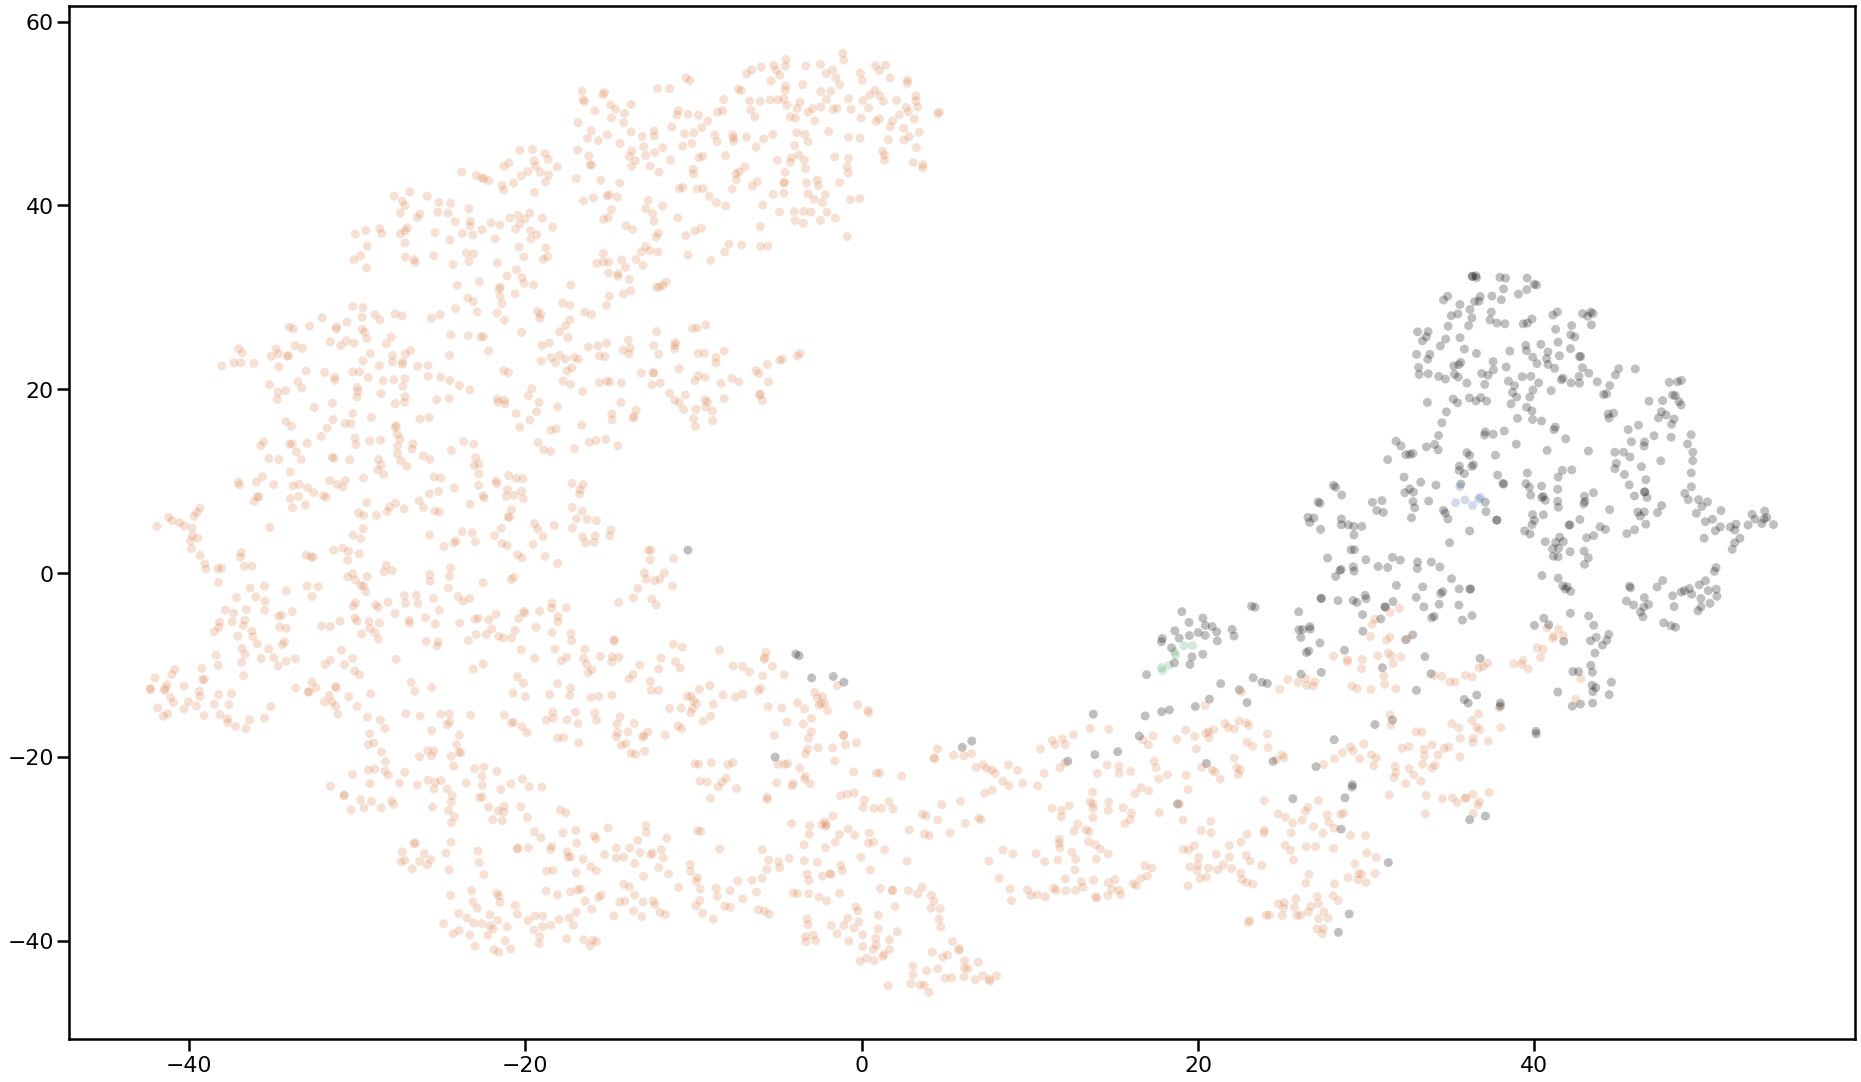

In [ ]:
%%time
import sklearn
import sklearn.cluster as cluster
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True, cluster_selection_epsilon=0.1)
#clusterer = cluster.AgglomerativeClustering({'n_clusters':512, 'linkage':'ward'})
clusterer.fit(arr2)

# clusterer = sklearn.cluster.AgglomerativeClustering(
#     n_clusters = None,
#     #n_clusters=1000, 
#     affinity='cosine', 
#     memory=None, 
#     connectivity=None, 
#     compute_full_tree='auto', 
#     linkage='complete', 
#     distance_threshold=0.7, 
#     compute_distances=False
# )
clusterer.fit(arr2)
print(100. * clusterer.labels_[clusterer.labels_ != -1].shape[0] / clusterer.labels_.shape[0], np.unique(clusterer.labels_).shape[0] - 1)

sns.set_context('poster')
sns.set_color_codes()
X = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(arr2)

plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
plt.figure(figsize=(32, 19))
palette = sns.color_palette('deep', np.unique(clusterer.labels_).max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in clusterer.labels_]
plt.scatter(X.T[0], X.T[1], c=colors, **plot_kwds)

for idx, id_ in enumerate(counts):
    print(idx, id_)

In [ ]:
domify = [word_dict[key] for key in word_dict.keys()]

In [ ]:
import json

with open('domify.json', 'w') as fp:
    json.dump(domify, fp)

In [ ]:
with open('domify.json', 'r') as fp:
    conv = json.load(fp)

In [ ]:
conv_dict = {}
for tmp_ in conv:
    conv_dict[tmp_['word']] = {}
    conv_dict[tmp_['word']]['cluster_id'] = tmp_['cluster_id']
    conv_dict[tmp_['word']]['weight'] = tmp_['weight']
    conv_dict[tmp_['word']]['dom_word'] = tmp_['dom_word']

In [ ]:
word = 'noises'
if word in conv_dict.keys():
    print(conv_dict[word]['dom_word'])

bag


In [ ]:
' '.join([conv_dict[word]['dom_word'] for word in comment.encode("ascii", "ignore").decode().strip().lower().split() if word in conv_dict.keys()])

'the burnt in transportation first okay bicycle sharing and the and i have tried most of them mechanism'

In [ ]:
' '.join(comment.encode("ascii", "ignore").decode().strip().lower().split())

"the revolution in transportation industry. india's first dockeless bicycle sharing and the best... and i have tried most of them ;)"